In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
with open("/content/drive/MyDrive/MLNBD/ML_Neuro/DATA ANALYTICS/trajectory_with_spike_data.json", "r") as f:
    trial_data = json.load(f)
with open("output.txt", "w") as file:
    # Redirect the print output to the file
    print(trial_data[0], file=file)

In [3]:
trial_data[0].keys()

dict_keys(['trial_id', 'start_time', 'stop_time', 'hand_pos', 'hand_vel', 'eye_pos', 'cursor_pos', 'target_pos', 'barrier_pos', 'trial_type', 'spike_data'])

In [4]:
import numpy as np

def preprocess_spike_times(spike_times, bin_size=0.01, duration=3.0):
    """
    Preprocess spike times into binned firing rates.
    """
    bins = np.arange(0, duration, bin_size)
    binned_spike_rates = np.histogram(spike_times, bins=bins)[0]
    return binned_spike_rates / np.max(binned_spike_rates)


In [5]:
def normalize_trajectory(trajectory):
    """
    Normalize trajectory to the range [0, 1].
    """
    return (trajectory - np.min(trajectory)) / (np.max(trajectory) - np.min(trajectory))


In [6]:
import torch
import torch.nn as nn

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim):
        super(DeepONet, self).__init__()
        # Branch network (for spike times)
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Trunk network (for time points)
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Output layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, branch_input, trunk_input):
        branch_out = self.branch_net(branch_input)
        trunk_out = self.trunk_net(trunk_input)
        return self.fc(branch_out * trunk_out)


CORRECT


In [9]:
data = trial_data

In [10]:
bin_size = 0.05  # Time bin size (e.g., 50ms)

def preprocess_trial_with_fixed_bins(trial, max_bins):
    """
    Preprocess a single trial, binning spike data and aligning it with hand velocity.
    Truncate or pad to ensure fixed number of bins.
    """
    hand_vel = np.array(trial["hand_vel"])  # Shape (T, 2)
    spike_data = trial["spike_data"]        # List of lists with spike timestamps

    # Calculate the number of bins
    num_bins = int((trial["stop_time"] - trial["start_time"]) / bin_size)

    # Preprocess spike data into fixed bins
    spike_features = np.zeros((len(spike_data), max_bins))  # Shape (num_neurons, max_bins)
    for neuron_idx, spikes in enumerate(spike_data):
        binned_spikes, _ = np.histogram(spikes, bins=np.linspace(0, trial["stop_time"], num_bins + 1))
        spike_features[neuron_idx, :min(num_bins, max_bins)] = binned_spikes[:max_bins]

    # Combine spike features across neurons (summed firing rate for each bin)
    spike_summary = np.sum(spike_features, axis=0)  # Shape (max_bins,)

    # Truncate or pad hand velocity to align with max_bins
    hand_vel = hand_vel[:max_bins] if len(hand_vel) >= max_bins else np.pad(hand_vel, ((0, max_bins - len(hand_vel)), (0, 0)))

    return hand_vel, spike_summary

# Find the maximum number of bins across trials
max_duration = max(trial["stop_time"] - trial["start_time"] for trial in data)
max_bins = int(max_duration / bin_size)

# Preprocess all trials
all_hand_velocities = []
all_spike_summaries = []

for trial in data:
    hand_vel, spike_summary = preprocess_trial_with_fixed_bins(trial, max_bins)
    all_hand_velocities.append(hand_vel)
    all_spike_summaries.append(spike_summary)

# Convert lists to arrays
all_hand_velocities = np.array(all_hand_velocities)  # Shape: (num_trials, max_bins, 2)
all_spike_summaries = np.array(all_spike_summaries)  # Shape: (num_trials, max_bins)

print(f"Hand velocities shape: {all_hand_velocities.shape}")
print(f"Spike summaries shape: {all_spike_summaries.shape}")


Hand velocities shape: (100, 71, 2)
Spike summaries shape: (100, 71)


In [11]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split # Import train_test_split from sklearn

# Split data into train and test sets
train_hand_velocities, test_hand_velocities, train_spike_summaries, test_spike_summaries = train_test_split(
    all_hand_velocities, all_spike_summaries, test_size=0.2, random_state=42
)

print(f"Training hand velocities shape: {train_hand_velocities.shape}")
print(f"Training spike summaries shape: {train_spike_summaries.shape}")
print(f"Testing hand velocities shape: {test_hand_velocities.shape}")
print(f"Testing spike summaries shape: {test_spike_summaries.shape}")

Training hand velocities shape: (80, 71, 2)
Training spike summaries shape: (80, 71)
Testing hand velocities shape: (20, 71, 2)
Testing spike summaries shape: (20, 71)


In [13]:
# Normalize spike data
train_spike_summaries = (train_spike_summaries - np.mean(train_spike_summaries)) / np.std(train_spike_summaries)
test_spike_summaries = (test_spike_summaries - np.mean(test_spike_summaries)) / np.std(test_spike_summaries)
# Normalize hand velocities
train_hand_velocities = (train_hand_velocities - np.mean(train_hand_velocities, axis=0)) / np.std(train_hand_velocities, axis=0)
test_hand_velocities = (test_hand_velocities - np.mean(test_hand_velocities, axis=0)) / np.std(test_hand_velocities, axis=0)


In [14]:
# Convert data to PyTorch tensors
train_spike_tensors = torch.tensor(train_spike_summaries, dtype=torch.float32)  # Shape: (num_trials, max_bins)
train_hand_vel_tensors = torch.tensor(train_hand_velocities, dtype=torch.float32)  # Shape: (num_trials, max_bins, 2)

test_spike_tensors = torch.tensor(test_spike_summaries, dtype=torch.float32)  # Shape: (num_trials, max_bins)
test_hand_vel_tensors = torch.tensor(test_hand_velocities, dtype=torch.float32)  # Shape: (num_trials, max_bins, 2)

# Time points input for the trunk network
max_bins = train_spike_tensors.shape[1]
time_points = torch.tensor(
    np.linspace(0, max_bins * bin_size, max_bins), dtype=torch.float32
).unsqueeze(1)  # Shape: (max_bins, 1)


In [15]:
num_epochs = 100
batch_size = 64
num_batches = len(train_spike_tensors) // batch_size

In [22]:
# Hyperparameters
input_dim = train_spike_tensors.shape[1]  # Number of bins (branch input)
time_dim = 1  # Single scalar input for trunk network
output_dim = 2  # x and y velocity components
hidden_dim = 128  # Hidden layer size

# Instantiate the model
# model = DeepONet(branch_input_dim=input_dim, trunk_input_dim=time_dim, hidden_dim=hidden_dim, output_dim=output_dim)


Training hand velocities shape: (80, 142)
Training spike summaries shape: (80, 71)
Training targets shape: (80, 2)
Testing hand velocities shape: (20, 142)
Testing spike summaries shape: (20, 71)
Testing targets shape: (20, 2)
Epoch 1/50, Loss: 340.2358
Epoch 2/50, Loss: 360.6076
Epoch 3/50, Loss: 310.2890
Epoch 4/50, Loss: 303.6874
Epoch 5/50, Loss: 238.9486
Epoch 6/50, Loss: 174.5527
Epoch 7/50, Loss: 99.6398
Epoch 8/50, Loss: 91.0173
Epoch 9/50, Loss: 89.1100
Epoch 10/50, Loss: 73.8896
Epoch 11/50, Loss: 89.0107
Epoch 12/50, Loss: 64.7483
Epoch 13/50, Loss: 69.9156
Epoch 14/50, Loss: 65.9390
Epoch 15/50, Loss: 56.9569
Epoch 16/50, Loss: 53.7822
Epoch 17/50, Loss: 57.6670
Epoch 18/50, Loss: 59.3114
Epoch 19/50, Loss: 49.9664
Epoch 20/50, Loss: 44.3022
Epoch 21/50, Loss: 62.2792
Epoch 22/50, Loss: 62.4709
Epoch 23/50, Loss: 77.0279
Epoch 24/50, Loss: 45.0791
Epoch 25/50, Loss: 54.7309
Epoch 26/50, Loss: 38.1772
Epoch 27/50, Loss: 35.5731
Epoch 28/50, Loss: 29.7129
Epoch 29/50, Loss: 3

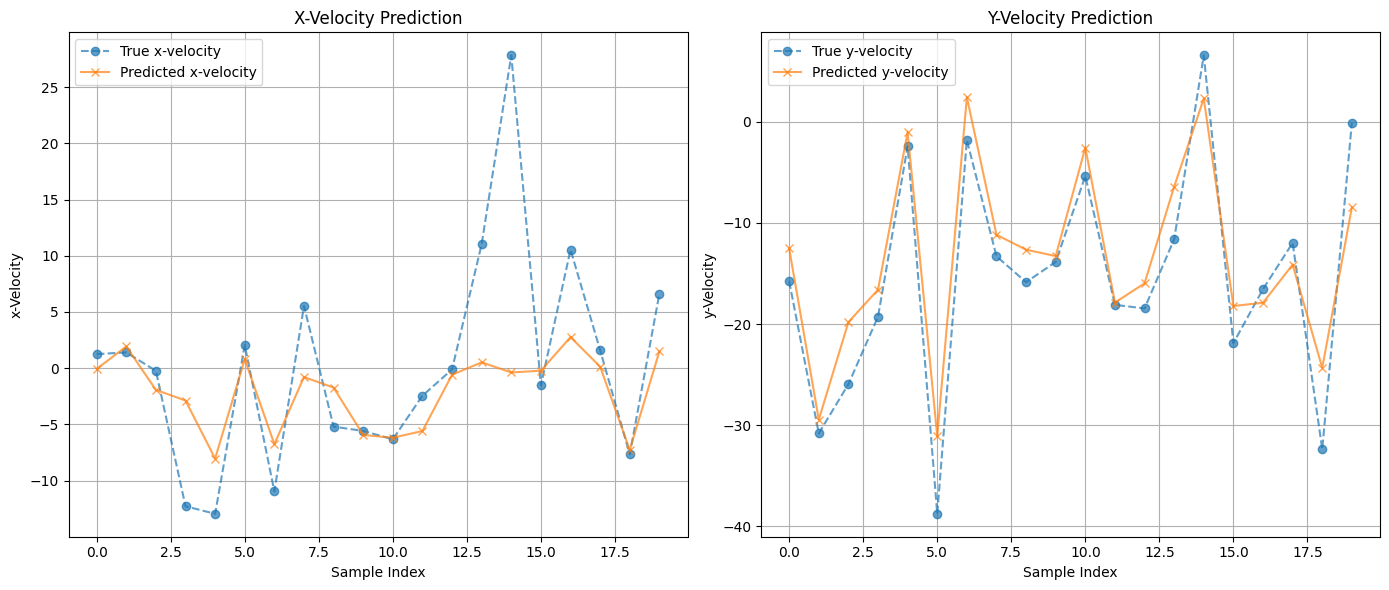

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Preprocessed Data: all_hand_velocities and all_spike_summaries
# Shape of all_hand_velocities: (num_trials, max_bins, 2)
# Shape of all_spike_summaries: (num_trials, max_bins)

# Flatten hand velocities for input to the trunk network
num_trials, max_bins, _ = all_hand_velocities.shape
all_hand_velocities_flattened = all_hand_velocities.reshape(num_trials, -1)  # Shape: (num_trials, max_bins * 2)

# Split data into train and test sets
train_hand_velocities, test_hand_velocities, train_spike_summaries, test_spike_summaries, train_targets, test_targets = train_test_split(
    all_hand_velocities_flattened, all_spike_summaries, all_hand_velocities[:, -1, :], test_size=0.2, random_state=42
)

print(f"Training hand velocities shape: {train_hand_velocities.shape}")
print(f"Training spike summaries shape: {train_spike_summaries.shape}")
print(f"Training targets shape: {train_targets.shape}")
print(f"Testing hand velocities shape: {test_hand_velocities.shape}")
print(f"Testing spike summaries shape: {test_spike_summaries.shape}")
print(f"Testing targets shape: {test_targets.shape}")

# Define Dataset class
class SpikeVelocityDataset(torch.utils.data.Dataset):
    def __init__(self, hand_velocities, spike_summaries, targets):
        self.hand_velocities = hand_velocities
        self.spike_summaries = spike_summaries
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.spike_summaries[idx], dtype=torch.float32),
            torch.tensor(self.hand_velocities[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Create train and test datasets and DataLoaders
train_dataset = SpikeVelocityDataset(train_hand_velocities, train_spike_summaries, train_targets)
test_dataset = SpikeVelocityDataset(test_hand_velocities, test_spike_summaries, test_targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Model
class SpikeVelocityDeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim, output_dim, n_heads=4, dropout=0.1):
        super(SpikeVelocityDeepONet, self).__init__()

        # Branch Network
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Trunk Network
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Attention Mechanism
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=n_heads, dropout=dropout)

        # Output Layer for 2D Velocity
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, spike_summary, hand_velocity):
        # Branch Network
        branch_output = self.branch_net(spike_summary)

        # Trunk Network
        trunk_output = self.trunk_net(hand_velocity)

        # Reshape for Attention
        branch_output = branch_output.unsqueeze(0)  # [1, batch_size, hidden_dim]
        trunk_output = trunk_output.unsqueeze(0)  # [1, batch_size, hidden_dim]

        # Attention Fusion
        attention_output, _ = self.attention(branch_output, trunk_output, trunk_output)
        attention_output = attention_output.squeeze(0)  # [batch_size, hidden_dim]

        # Output Prediction
        output = self.output_layer(attention_output)
        return output

# Model Parameters
branch_input_dim = train_spike_summaries.shape[1]  # Number of bins
trunk_input_dim = train_hand_velocities.shape[1]  # Flattened hand velocities (max_bins * 2)
hidden_dim = 128
output_dim = 2  # Predicting both x- and y-velocity
learning_rate = 1e-3
epochs = 50

# Initialize Model, Loss, Optimizer, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikeVelocityDeepONet(branch_input_dim, trunk_input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Training Function
def train_deeponet(model, train_loader, criterion, optimizer, scheduler, device, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for spike_summary, hand_velocity, targets in train_loader:
            spike_summary, hand_velocity, targets = (
                spike_summary.to(device),
                hand_velocity.to(device),
                targets.to(device),
            )
            optimizer.zero_grad()
            outputs = model(spike_summary, hand_velocity)
            loss = criterion(outputs, targets)  # Loss for 2D targets
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Train the Model
train_deeponet(model, train_loader, criterion, optimizer, scheduler, device, epochs)

# Evaluation Function
def evaluate_deeponet_2d(model, test_loader, device):
    model.eval()
    true_values = []
    predicted_values = []
    with torch.no_grad():
        for spike_summary, hand_velocity, targets in test_loader:
            spike_summary, hand_velocity, targets = (
                spike_summary.to(device),
                hand_velocity.to(device),
                targets.to(device),
            )
            outputs = model(spike_summary, hand_velocity)
            true_values.append(targets.cpu().numpy())
            predicted_values.append(outputs.cpu().numpy())
    return np.concatenate(true_values), np.concatenate(predicted_values)

# Evaluate the Model
true_values, predicted_values = evaluate_deeponet_2d(model, test_loader, device)

# Plot True vs Predicted Values for 2D Velocity
def plot_2d_velocity(true_values, predicted_values):
    plt.figure(figsize=(14, 6))

    # Plot X-Velocity
    plt.subplot(1, 2, 1)
    plt.plot(true_values[:, 0], label="True x-velocity", linestyle="--", marker="o", alpha=0.7)
    plt.plot(predicted_values[:, 0], label="Predicted x-velocity", linestyle="-", marker="x", alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel("x-Velocity")
    plt.title("X-Velocity Prediction")
    plt.legend()
    plt.grid()

    # Plot Y-Velocity
    plt.subplot(1, 2, 2)
    plt.plot(true_values[:, 1], label="True y-velocity", linestyle="--", marker="o", alpha=0.7)
    plt.plot(predicted_values[:, 1], label="Predicted y-velocity", linestyle="-", marker="x", alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel("y-Velocity")
    plt.title("Y-Velocity Prediction")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.savefig("velocity_prediction.png")
    plt.show()

# Plot 2D Velocity
plot_2d_velocity(true_values, predicted_values)


Normalised Data

Training hand velocities shape: (80, 142)
Training spike summaries shape: (80, 71)
Training targets shape: (80, 2)
Testing hand velocities shape: (20, 142)
Testing spike summaries shape: (20, 71)
Testing targets shape: (20, 2)
Epoch 1/50, Loss: 0.3056
Epoch 2/50, Loss: 0.1571
Epoch 3/50, Loss: 0.0703
Epoch 4/50, Loss: 0.0531
Epoch 5/50, Loss: 0.0353
Epoch 6/50, Loss: 0.0393
Epoch 7/50, Loss: 0.0271
Epoch 8/50, Loss: 0.0431
Epoch 9/50, Loss: 0.0193
Epoch 10/50, Loss: 0.0174
Epoch 11/50, Loss: 0.0182
Epoch 12/50, Loss: 0.0166
Epoch 13/50, Loss: 0.0144
Epoch 14/50, Loss: 0.0130
Epoch 15/50, Loss: 0.0126
Epoch 16/50, Loss: 0.0103
Epoch 17/50, Loss: 0.0117
Epoch 18/50, Loss: 0.0122
Epoch 19/50, Loss: 0.0131
Epoch 20/50, Loss: 0.0120
Epoch 21/50, Loss: 0.0093
Epoch 22/50, Loss: 0.0093
Epoch 23/50, Loss: 0.0109
Epoch 24/50, Loss: 0.0140
Epoch 25/50, Loss: 0.0110
Epoch 26/50, Loss: 0.0097
Epoch 27/50, Loss: 0.0121
Epoch 28/50, Loss: 0.0097
Epoch 29/50, Loss: 0.0120
Epoch 30/50, Loss: 0.0127
Ep

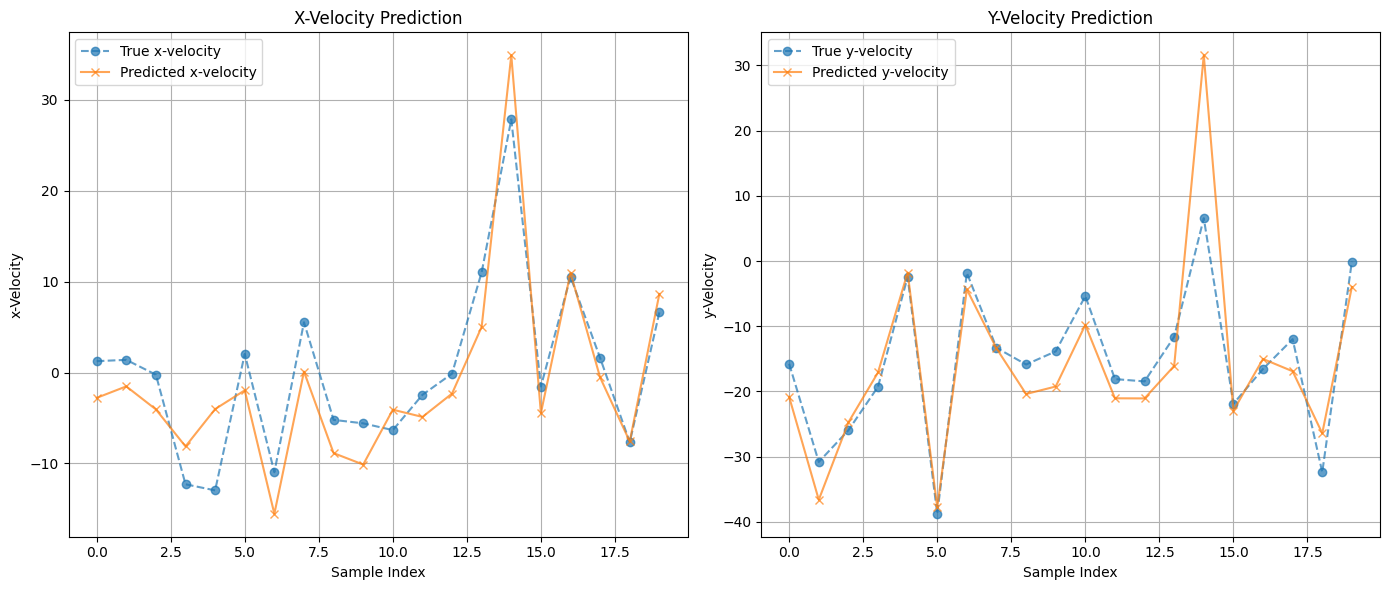

In [29]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Initialize scalers
spike_scaler = MinMaxScaler()
velocity_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()  # Separate scaler for targets

# Normalize spike summaries
all_spike_summaries_normalized = spike_scaler.fit_transform(all_spike_summaries.reshape(-1, max_bins)).reshape(-1, max_bins)

# Normalize hand velocities (flattened)
num_trials, max_bins, _ = all_hand_velocities.shape
all_hand_velocities_flattened = all_hand_velocities.reshape(num_trials, -1)
all_hand_velocities_normalized = velocity_scaler.fit_transform(all_hand_velocities_flattened)

# Normalize targets (final bin velocities)
all_targets = all_hand_velocities[:, -1, :]  # Shape: (num_trials, 2)
all_targets_normalized = target_scaler.fit_transform(all_targets)

# Split data into train and test sets
train_hand_velocities, test_hand_velocities, train_spike_summaries, test_spike_summaries, train_targets, test_targets = train_test_split(
    all_hand_velocities_normalized, all_spike_summaries_normalized, all_targets_normalized, test_size=0.2, random_state=42
)

print(f"Training hand velocities shape: {train_hand_velocities.shape}")
print(f"Training spike summaries shape: {train_spike_summaries.shape}")
print(f"Training targets shape: {train_targets.shape}")
print(f"Testing hand velocities shape: {test_hand_velocities.shape}")
print(f"Testing spike summaries shape: {test_spike_summaries.shape}")
print(f"Testing targets shape: {test_targets.shape}")


# Define Dataset class
class SpikeVelocityDataset(torch.utils.data.Dataset):
    def __init__(self, hand_velocities, spike_summaries, targets):
        self.hand_velocities = hand_velocities
        self.spike_summaries = spike_summaries
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.spike_summaries[idx], dtype=torch.float32),
            torch.tensor(self.hand_velocities[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Create train and test datasets and DataLoaders
train_dataset = SpikeVelocityDataset(train_hand_velocities, train_spike_summaries, train_targets)
test_dataset = SpikeVelocityDataset(test_hand_velocities, test_spike_summaries, test_targets)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Model
class SpikeVelocityDeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim, output_dim, n_heads=4, dropout=0.1):
        super(SpikeVelocityDeepONet, self).__init__()

        # Branch Network
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Trunk Network
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Attention Mechanism
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=n_heads, dropout=dropout)

        # Output Layer for 2D Velocity
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, spike_summary, hand_velocity):
        # Branch Network
        branch_output = self.branch_net(spike_summary)

        # Trunk Network
        trunk_output = self.trunk_net(hand_velocity)

        # Reshape for Attention
        branch_output = branch_output.unsqueeze(0)  # [1, batch_size, hidden_dim]
        trunk_output = trunk_output.unsqueeze(0)  # [1, batch_size, hidden_dim]

        # Attention Fusion
        attention_output, _ = self.attention(branch_output, trunk_output, trunk_output)
        attention_output = attention_output.squeeze(0)  # [batch_size, hidden_dim]

        # Output Prediction
        output = self.output_layer(attention_output)
        return output

# Model Parameters
branch_input_dim = train_spike_summaries.shape[1]  # Number of bins
trunk_input_dim = train_hand_velocities.shape[1]  # Flattened hand velocities (max_bins * 2)
hidden_dim = 128
output_dim = 2  # Predicting both x- and y-velocity
learning_rate = 1e-3
epochs = 50

# Initialize Model, Loss, Optimizer, and Scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpikeVelocityDeepONet(branch_input_dim, trunk_input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Training Function
def train_deeponet(model, train_loader, criterion, optimizer, scheduler, device, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for spike_summary, hand_velocity, targets in train_loader:
            spike_summary, hand_velocity, targets = (
                spike_summary.to(device),
                hand_velocity.to(device),
                targets.to(device),
            )
            optimizer.zero_grad()
            outputs = model(spike_summary, hand_velocity)
            loss = criterion(outputs, targets)  # Loss for 2D targets
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Train the Model
train_deeponet(model, train_loader, criterion, optimizer, scheduler, device, epochs)

# Evaluation Function
def evaluate_deeponet_2d(model, test_loader, device):
    model.eval()
    true_values = []
    predicted_values = []
    with torch.no_grad():
        for spike_summary, hand_velocity, targets in test_loader:
            spike_summary, hand_velocity, targets = (
                spike_summary.to(device),
                hand_velocity.to(device),
                targets.to(device),
            )
            outputs = model(spike_summary, hand_velocity)
            true_values.append(targets.cpu().numpy())
            predicted_values.append(outputs.cpu().numpy())
    return np.concatenate(true_values), np.concatenate(predicted_values)

# Evaluate the Model
true_values_normalized, predicted_values_normalized = evaluate_deeponet_2d(model, test_loader, device)

# Inverse-transform the normalized values back to the original range
# Evaluate the Model
true_values_normalized, predicted_values_normalized = evaluate_deeponet_2d(model, test_loader, device)

# Use target_scaler to inverse-transform the normalized values
true_values = target_scaler.inverse_transform(true_values_normalized)
predicted_values = target_scaler.inverse_transform(predicted_values_normalized)

# Plot True vs Predicted Values for 2D Velocity
def plot_2d_velocity(true_values, predicted_values):
    plt.figure(figsize=(14, 6))

    # Plot X-Velocity
    plt.subplot(1, 2, 1)
    plt.plot(true_values[:, 0], label="True x-velocity", linestyle="--", marker="o", alpha=0.7)
    plt.plot(predicted_values[:, 0], label="Predicted x-velocity", linestyle="-", marker="x", alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel("x-Velocity")
    plt.title("X-Velocity Prediction")
    plt.legend()
    plt.grid()

    # Plot Y-Velocity
    plt.subplot(1, 2, 2)
    plt.plot(true_values[:, 1], label="True y-velocity", linestyle="--", marker="o", alpha=0.7)
    plt.plot(predicted_values[:, 1], label="Predicted y-velocity", linestyle="-", marker="x", alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel("y-Velocity")
    plt.title("Y-Velocity Prediction")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.savefig("velocity_prediction.png")
    plt.show()

# Plot 2D Velocity
plot_2d_velocity(true_values, predicted_values)



Test MSE: 0.0066
Test MAE: 0.0546
Test R²: 0.6784


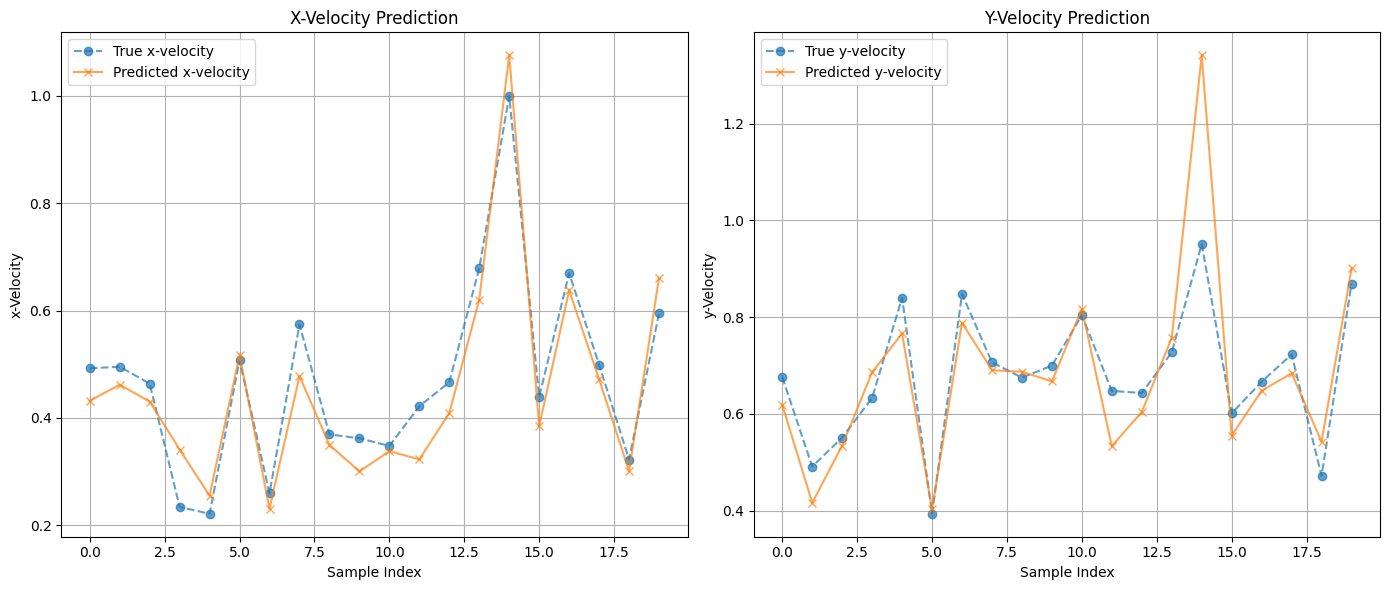

In [27]:
# Evaluate the model and compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_deeponet_with_metrics(model, test_loader, device):
    model.eval()
    true_values = []
    predicted_values = []
    with torch.no_grad():
        for spike_summary, hand_velocity, targets in test_loader:
            spike_summary, hand_velocity, targets = (
                spike_summary.to(device),
                hand_velocity.to(device),
                targets.to(device),
            )
            outputs = model(spike_summary, hand_velocity)
            true_values.append(targets.cpu().numpy())
            predicted_values.append(outputs.cpu().numpy())

    true_values = np.concatenate(true_values)
    predicted_values = np.concatenate(predicted_values)

    # Compute Metrics
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    return true_values, predicted_values, mse, mae, r2

true_values, predicted_values, mse, mae, r2 = evaluate_deeponet_with_metrics(model, test_loader, device)

# Plot the results
plot_2d_velocity(true_values, predicted_values)
